#RNN vs LSTM vs GRU

##Importing libraries and data

In [18]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import time
import re

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense, Flatten, SimpleRNN, Conv1D,
                                     Bidirectional, GRU, LSTM,
                                     BatchNormalization, Dropout, Input, MaxPooling1D,
                                     Embedding, TextVectorization)
from tensorflow.keras.losses import (CategoricalCrossentropy,
                                     SparseCategoricalCrossentropy)
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("falgunipatel19/biomedical-text-publication-classification")

print("Path to dataset files:", path)

100%|██████████| 55.9M/55.9M [00:02<00:00, 26.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/falgunipatel19/biomedical-text-publication-classification/versions/1


In [3]:
!cp -r /root/.cache/kagglehub/datasets/falgunipatel19/biomedical-text-publication-classification/ /content/

##Exploring the dataset

###functions

In [4]:
def plot_class_distribution(data, target_column="Target"):
    # Get the value counts of the target column
    counts = data[target_column].value_counts()

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the bar plot
    ax1 = sns.barplot(x=counts.index, y=counts.values, ax=axs[0])

    # Annotate the bar plot with the counts
    for i, p in enumerate(ax1.patches):
        ax1.annotate(f'{counts.iloc[i]}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom',
                     fontsize=10)

    # Set titles and labels for the bar plot
    axs[0].set_title('Number of Samples per Class')
    axs[0].set_xlabel('Classes')
    axs[0].set_ylabel('Number of Samples')

    # Plot the pie chart
    axs[1].pie(counts.values,
               autopct="%.1f%%",
               labels=counts.index)
    axs[1].set_title('Distribution of Cancer Types')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_class_distribution(data)


In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(data, target_column="Target", target_value="Thyroid_Cancer", text_column="Text"):
    # Filter the data based on the target value
    target_text = data[data[target_column] == target_value][text_column].values
    target_text = ' '.join(target_text)

    # Create the word cloud
    plt.figure(figsize=(10, 8))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(target_text)

    # Display the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {target_value}')
    plt.axis('off')
    plt.show()

# Example usage:
# plot_wordcloud(data)

In [6]:
# Function to plot loss, accuracy and best epoch

def learning_curves_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')

    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

###Working with the dataset

In [7]:
data = pd.read_csv("/content/biomedical-text-publication-classification/versions/1/alldata_1_for_kaggle.csv"
                   , encoding="latin1")
data.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [8]:
#Checking for zeros, missign information, duplicates, and excluding this informations
data.isna().sum()
data.duplicated().sum()
data = data.drop('Unnamed: 0', axis =1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7570 non-null   object
 1   a       7570 non-null   object
dtypes: object(2)
memory usage: 118.4+ KB


In [9]:
data = data.rename(columns={"0": "Target", "a":"Text"})
data["Text"].iloc[0]

"Thyroid surgery in  children in a single institution from Osama Ibrahim Almosallama Ali Aseerib Ahmed Alhumaida Ali S AlZahranic Saif Alsobhib Saud AlShanafeybFrom the  aDepartment of Surgery College of Medicine Qassim University Buraidah Al Qassim Saudi Arabia  bDepartment of Surgery King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia cDepartment of Medicine King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia Correspondence   Dr  Osama Ibrahim  Almosallam  Department of  Surgery  College  of  Medicine Qassim  University  PO  Box   Buraidah  Al  Qassim   Saudi  Arabia  osama_iaahotmailcom ORCID orcid0000000290367564        Citation  Almosallam OI Aseeri A Alhumaid A AlZahrani AS Alsobhi S AlShanafey S Thyroid surgery in  children  in  a  single  institution  from   Ann  Saudi  Med         Received January  Accepted May  Published August  Copyright Copyright   Annals of Saudi Medicine Saudi Arabia This is an   access  under the Creative Commons A

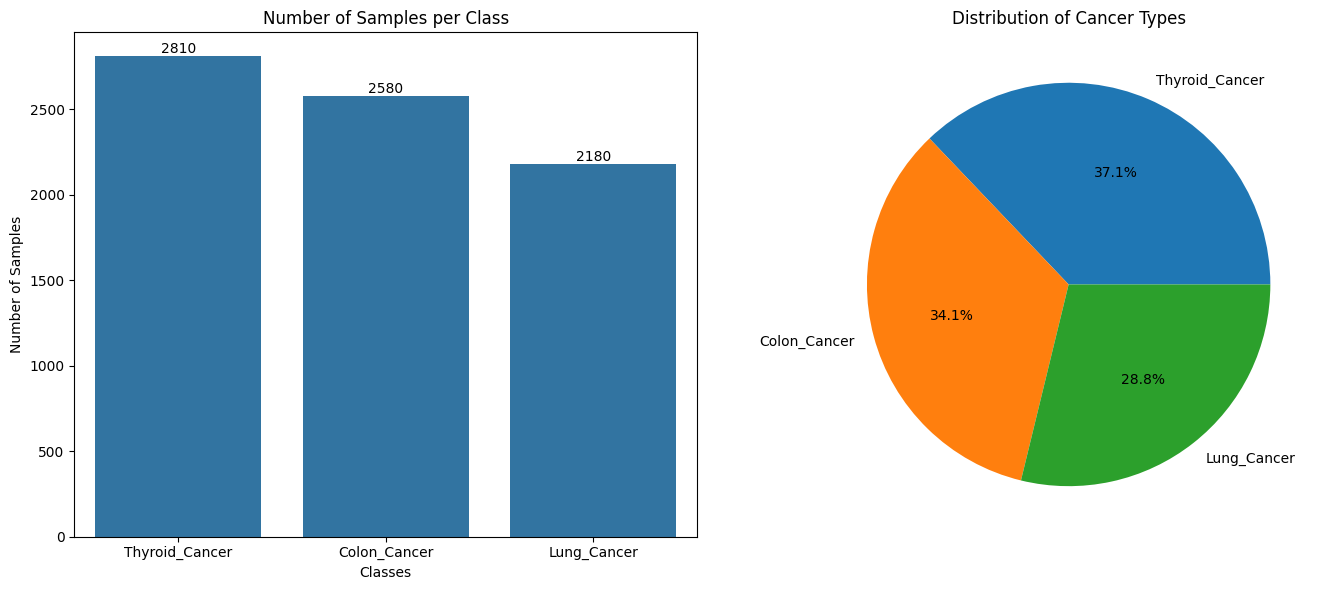

In [10]:
#Plotting data distributions
plot_class_distribution(data)

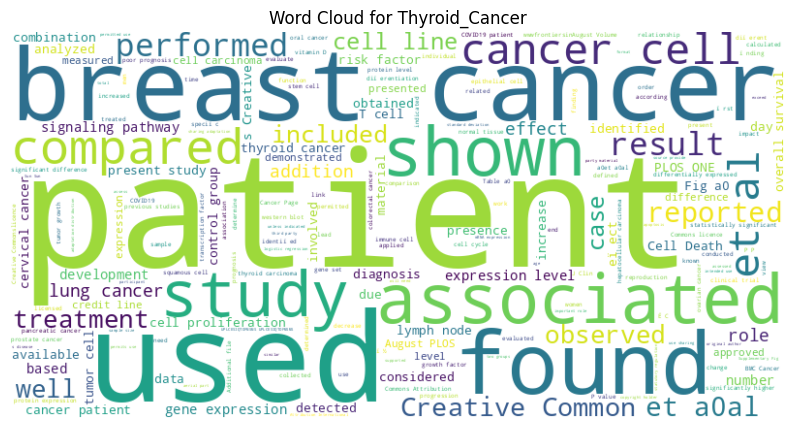

In [11]:
#Important words related to thyroid cancer
plot_wordcloud(data, target_column="Target", target_value="Thyroid_Cancer", text_column="Text")

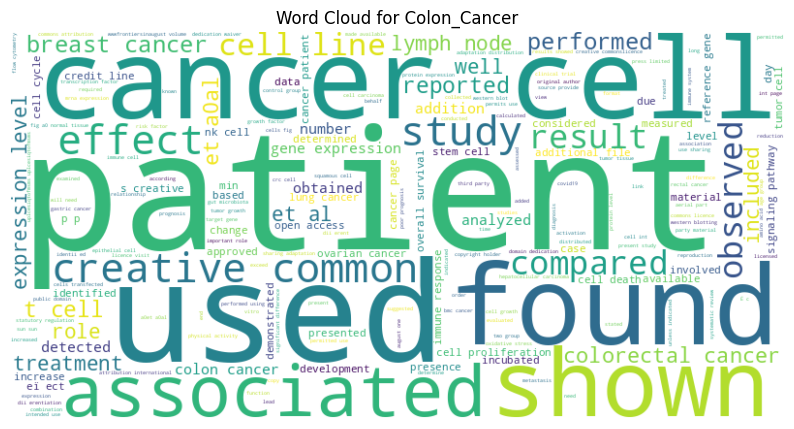

In [12]:
#Important words related to colon cancer
plot_wordcloud(data, target_column="Target", target_value="Colon_Cancer", text_column="Text")

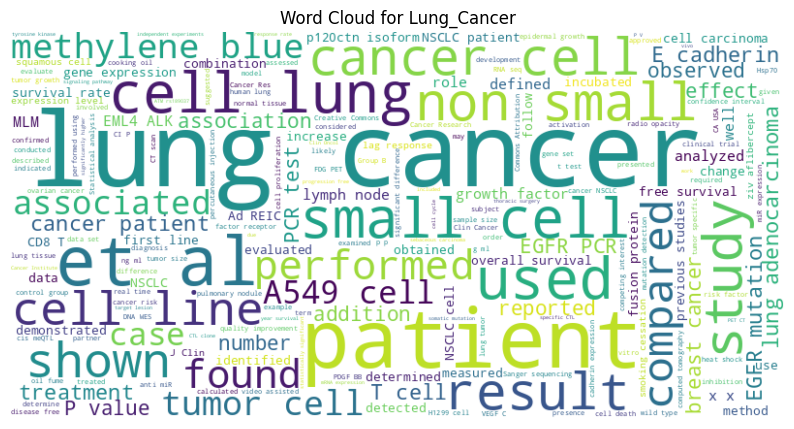

In [13]:
#Important words related to thyroid cancer
plot_wordcloud(data, target_column="Target", target_value="Lung_Cancer", text_column="Text")

##Data processing

In [14]:
#Parameters for the model
vocab_size = 20000  # Size of the vocabulary
embedding_dim = 128  # Dimension of the word embeddings
max_length = 250  # Maximum length of the sequences

#Classification of x and y
text = data["Text"].values
labels = data["Target"].values

In [15]:
#Vectorize words and pad them to sequences
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data["Text"])

sequences = tokenizer.texts_to_sequences(data["Text"])

padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [16]:
#Split dataset in train, validation and testing
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2,
                                                    random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_val, y_val, test_size=0.5,
                                                       random_state=42)

print('Train Set Shape: ', X_train.shape)
print('Validation Set Shape: ', X_valid.shape)
print('Test Set Shape: ', X_test.shape)

Train Set Shape:  (6056, 250)
Validation Set Shape:  (757, 250)
Test Set Shape:  (757, 250)


In [17]:
# Initialize the LabelEncoder
encoder = LabelEncoder()

# The encoder assigns integer values to each unique class in the target labels
y_train = encoder.fit_transform(y_train)
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test)

# Convert the integer-encoded labels to one-hot encoded vectors
# One-hot encoding is used for multi-class classification tasks where each class is represented as a binary vector
y_train = to_categorical(y_train, num_classes=3)
y_valid = to_categorical(y_valid, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

##Modeling

###Simple RNN

In [19]:
# Define the model
rnn_model = Sequential()
rnn_model.add(Input(shape=(max_length,)))
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
rnn_model.add(SimpleRNN(128))
rnn_model.add(Dense(3, activation='softmax'))

rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,593,283 (9.89 MB)

 Trainable params: 2,593,283 (9.89 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#Compile the model
rnn_model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

#Set hyperparameters
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=2,
                              min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

In [21]:
#Train the model
rnn_history=rnn_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=15,
    batch_size=32,
    callbacks=callbacks)

Epoch 1/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.5800 - loss: 0.8676 - val_accuracy: 0.9670 - val_loss: 0.0732 - learning_rate: 0.0010
Epoch 2/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9817 - loss: 0.0480 - val_accuracy: 0.9749 - val_loss: 0.0483 - learning_rate: 0.0010
Epoch 3/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9884 - loss: 0.0287 - val_accuracy: 0.9247 - val_loss: 0.1603 - learning_rate: 0.0010
Epoch 4/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9039 - loss: 0.2655
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9035 - loss: 0.2666 - val_accuracy: 0.7873 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 5/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8467 - loss: 0.5199 - val_accuracy: 0.9009 - val_loss: 0.3981 - learning_rate: 2.0000e-04
Epoch 6/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9241 - loss

###LSTM

In [22]:
lstm_model = Sequential()
lstm_model.add(Input(shape=(max_length,)))
lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 250, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,691,971 (10.27 MB)

 Trainable params: 2,691,971 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
lstm_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

lstm_history=lstm_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=15,
    batch_size=32)

Epoch 1/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6142 - loss: 0.8099 - val_accuracy: 0.9115 - val_loss: 0.2367
Epoch 2/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9441 - loss: 0.1652 - val_accuracy: 0.9657 - val_loss: 0.1102
Epoch 3/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9826 - loss: 0.0419 - val_accuracy: 0.9802 - val_loss: 0.0532
Epoch 4/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9791 - loss: 0.0448 - val_accuracy: 0.9736 - val_loss: 0.0575
Epoch 5/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9801 - loss: 0.0348 - val_accuracy: 0.9683 - val_loss: 0.0534
Epoch 6/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9791 - loss: 0.0344 - val_accuracy: 0.9855 - val_loss: 0.0333
Epoch 7/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9830 - loss: 0.0312 - val_accuracy: 0.9709 - val_loss: 0.0399
Epoch 8/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9812 - loss: 0.0326 - val_accu

###GRU

In [24]:
bigru_model = Sequential()
bigru_model.add(Input(shape=(max_length,)))
bigru_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
bigru_model.add(Bidirectional(GRU(128, return_sequences=True)))
bigru_model.add(Bidirectional(GRU(64)))
bigru_model.add(Dense(3, activation='softmax'))
bigru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 250, 256)            │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,882,179 (10.99 MB)

 Trainable params: 2,882,179 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
bigru_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

bigru_history=bigru_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=15,
    batch_size=32)

Epoch 1/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.6705 - loss: 0.6470 - val_accuracy: 0.9921 - val_loss: 0.0315
Epoch 2/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9914 - loss: 0.0236 - val_accuracy: 0.9908 - val_loss: 0.0156
Epoch 3/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9953 - loss: 0.0105 - val_accuracy: 0.9894 - val_loss: 0.0203
Epoch 4/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9930 - loss: 0.0128 - val_accuracy: 0.9960 - val_loss: 0.0106
Epoch 5/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9940 - loss: 0.0101 - val_accuracy: 0.9894 - val_loss: 0.0172
Epoch 6/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9948 - loss: 0.0097 - val_accuracy: 0.9894 - val_loss: 0.0139
Epoch 7/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9942 - loss: 0.0110 - val_accuracy: 0.9947 - val_loss: 0.0116
Epoch 8/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9931 - loss: 0.0116 - val

##Evaluate

###Functions

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot training & validation accuracy and loss
def plot_learning_curve(histories, labels):
    # Set the style and palette for the plot
    sns.set(style="whitegrid")  # Use Seaborn grid style
    plt.figure(figsize=(14, 6))

    # Define color palette
    colors = sns.color_palette("Set1", n_colors=len(histories))

    # Plot accuracy for each model
    plt.subplot(1, 2, 1)
    for history, label, color in zip(histories, labels, colors):
        plt.plot(history.history['accuracy'], label=f'{label} - Training Accuracy', color=color, linestyle='-', marker='o', markersize=6)
        plt.plot(history.history['val_accuracy'], label=f'{label} - Validation Accuracy', color=color, linestyle='--', marker='x', markersize=6)
    plt.title('Training and Validation Accuracy', fontsize=16, weight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot loss for each model
    plt.subplot(1, 2, 2)
    for history, label, color in zip(histories, labels, colors):
        plt.plot(history.history['loss'], label=f'{label} - Training Loss', color=color, linestyle='-', marker='o', markersize=6)
        plt.plot(history.history['val_loss'], label=f'{label} - Validation Loss', color=color, linestyle='--', marker='x', markersize=6)
    plt.title('Training and Validation Loss', fontsize=16, weight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


# Function to plot confusion matrices side by side with improvements
def plot_confusion_matrices_side_by_side(models, X_test, y_test, class_labels, labels):
    fig, axes = plt.subplots(1, len(models), figsize=(18, 6))  # Adjusted figsize for better spacing

    # Define a color palette using seaborn
    cmap = sns.color_palette("Blues", as_cmap=True)  # Blue color map for a clean look

    for ax, model, label in zip(axes, models, labels):
        y_pred = np.argmax(model.predict(X_test), axis=-1)
        y_true = np.argmax(y_test, axis=-1)

        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)

        # Normalize the confusion matrix if needed
        conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        # Create a heatmap with improved aesthetics
        sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap=cmap, xticklabels=class_labels,
                    yticklabels=class_labels, annot_kws={"size": 14, 'weight': 'bold'}, linewidths=1,
                    linecolor='white', cbar=True, cbar_kws={'label': 'Normalized'}, ax=ax)

        # Titles and labels
        ax.set_title(f'{label} Confusion Matrix', fontsize=18, weight='bold')
        ax.set_xlabel('Predicted Label', fontsize=14)
        ax.set_ylabel('True Label', fontsize=14)

        # Rotate the tick labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

        # Add gridlines with subtle visibility
        ax.grid(False)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Function to evaluate model performance and return confusion matrices
def evaluate_model(model, X_test, y_test, class_labels):
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Predict the classes for the test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    y_true = np.argmax(y_test, axis=-1)

    # Assign a specific name to each model based on the input
    if model == rnn_model:
        model_name = "Simple RNN"
    elif model == lstm_model:
        model_name = "LSTM"
    elif model == bigru_model:
        model_name = "Bi-GRU"
    else:
        model_name = "Unknown Model"

    # Print the evaluation results
    print(f"{model_name} Loss: {loss:.4f}")
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Return the confusion matrix for later use
    return confusion_matrix(y_true, y_pred)

###Metrics

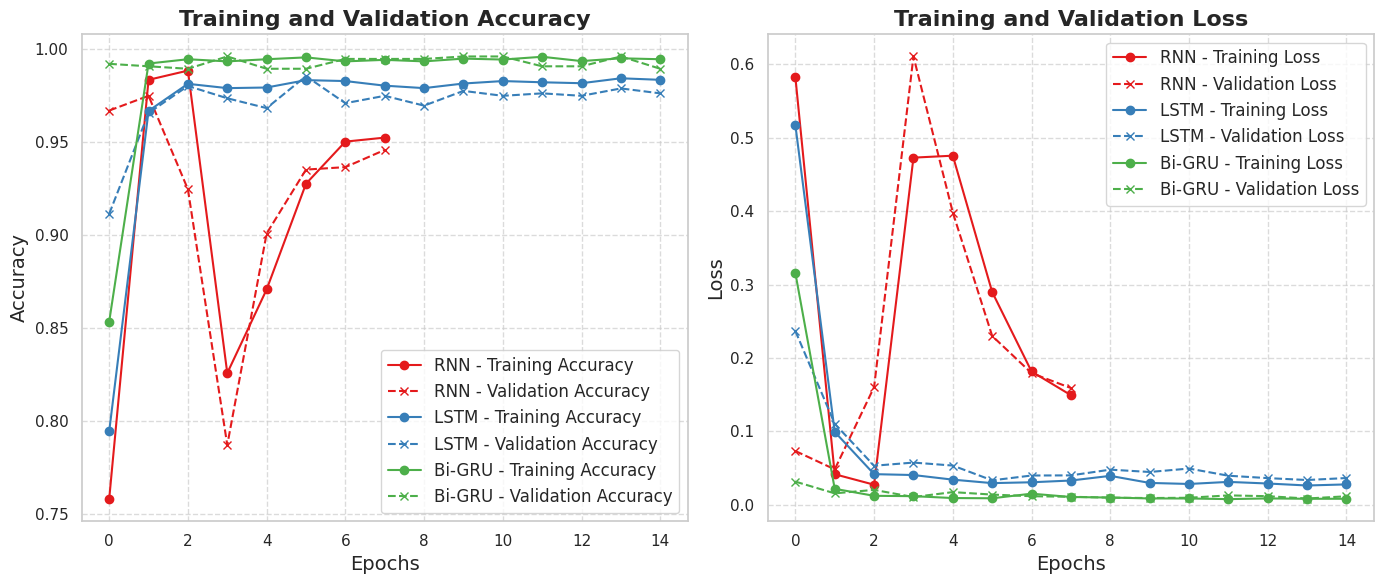

In [34]:
# List of models and their corresponding histories
models = [rnn_model, lstm_model, bigru_model]
histories = [rnn_history, lstm_history, bigru_history]
labels = ['RNN', 'LSTM', 'Bi-GRU']
class_labels = ['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer']

# Plot learning curves for all models
plot_learning_curve(histories, labels)

In [46]:
# Evaluate each model and gather confusion matrices
models = [rnn_model, lstm_model, bigru_model]
class_labels = ['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer']

for model in models:
    evaluate_model(model, X_test, y_test, class_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Simple RNN Loss: 0.0443
Simple RNN Test Accuracy: 0.9775
Simple RNN Classification Report:
                precision    recall  f1-score   support

Thyroid_Cancer       1.00      0.94      0.97       263
  Colon_Cancer       1.00      1.00      1.00       204
   Lung_Cancer       0.94      1.00      0.97       290

      accuracy                           0.98       757
     macro avg       0.98      0.98      0.98       757
  weighted avg       0.98      0.98      0.98       757

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM Loss: 0.0285
LSTM Test Accuracy: 0.9828
LSTM Classification Report:
                precision    recall  f1-score   support

Thyroid_Cancer       0.96      0.99      0.98       263
  Colon_Cancer       1.00      1.00      1.00       204
   Lung_Cancer       0.99      0.97      0.98       290

      accuracy                           0.98       757
     macro avg       0.98      0.98      0.98       757
  weighted avg       0.98

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


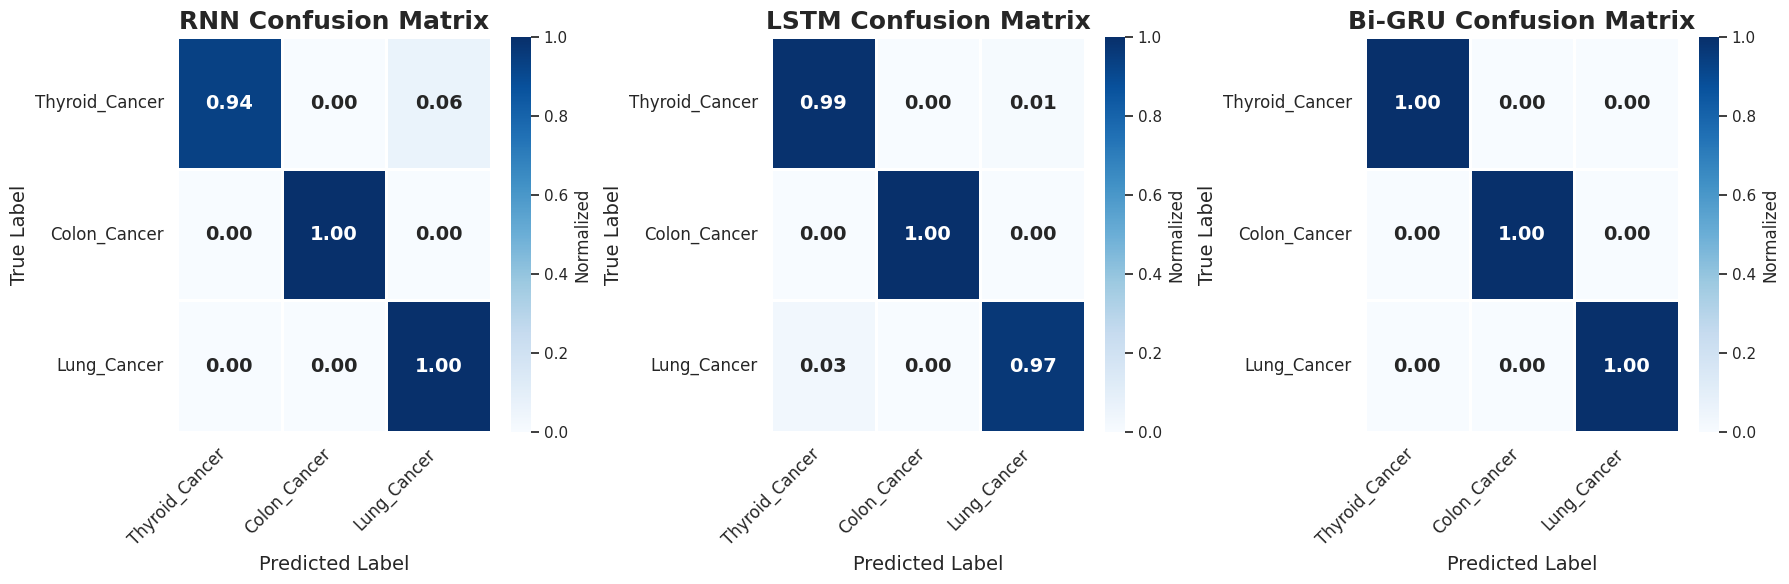

In [47]:
# Plot confusion matrices side by side
plot_confusion_matrices_side_by_side(models, X_test, y_test, class_labels, labels)

#CNN+LSTM

##Importing libraries and data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2


In [3]:
!cp -r /root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/ /content/

##Modeling

###Fine tuning with ResNet50 for feature extraction

In [4]:
#Importing the trained model in imagenet dataset, only the convolutional part for feature extraction (excluding the classification part - fully connected layers)
r50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

In [5]:
#Data processing and feature extraction using resnet50
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train = []
y_train = []
image_size = 224

for i in labels:
    folderPath = os.path.join('/content/brain-tumor-classification-mri/versions/2/','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = r50.predict(img, verbose=0)
        feature = feature.reshape((1, 7 * 7 * 2048))
        X_train.append(feature)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/brain-tumor-classification-mri/versions/2/','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = r50.predict(img, verbose=0)
        feature = feature.reshape((1, 7 * 7 * 2048))
        X_train.append(feature)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:07<00:00, 10.29it/s]


###LSTM

In [6]:
#Dataset split in train, validation and test
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))

y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))

y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
#LSTM model
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(512, input_shape=(1, 100352), activation='relu', return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='softmax')
])
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 512)              │     206,571,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 256)              │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,605,764 (791.95 MB)

 Trainable params: 207,605,764 (791.95 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#Model compile and training
lstm_model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(monitor="val_accuracy",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

history = lstm_model.fit(X_train, y_train, validation_split=0.1,
                         epochs =25, verbose=1, batch_size=32,
                         callbacks=[tensorboard,checkpoint,reduce_lr])

In [9]:
history = lstm_model.fit(X_train, y_train, validation_split=0.1, epochs =25, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2964 - loss: 1.5310
Epoch 1: val_accuracy improved from -inf to 0.34354, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 94s 969ms/step - accuracy: 0.2966 - loss: 1.5307 - val_accuracy: 0.3435 - val_loss: 1.3248 - learning_rate: 0.0010
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3356 - loss: 1.3941
Epoch 2: val_accuracy improved from 0.34354 to 0.41497, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.3355 - loss: 1.3940 - val_accuracy: 0.4150 - val_loss: 1.2849 - learning_rate: 0.0010
Epoch 3/25
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3936 - loss: 1.2721
Epoch 3: val_accuracy improved from 0.41497 to 0.60544, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.3944 - loss: 1.2709 - val_accuracy: 0.6054 - val_loss: 0.9237 - learning_rate: 0.0010
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5288 - loss: 0.9928
Epoch 4: val_accuracy improved from 0.60544 to 0.67007, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.5290 - loss: 0.9923 - val_accuracy: 0.6701 - val_loss: 0.7282 - learning_rate: 0.0010
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6088 - loss: 0.8442
Epoch 5: val_accuracy improved from 0.67007 to 0.74830, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6091 - loss: 0.8437 - val_accuracy: 0.7483 - val_loss: 0.6244 - learning_rate: 0.0010
Epoch 6/25
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7154 - loss: 0.6537
Epoch 6: val_accuracy improved from 0.74830 to 0.84014, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7158 - loss: 0.6533 - val_accuracy: 0.8401 - val_loss: 0.4752 - learning_rate: 0.0010
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7891 - loss: 0.5317
Epoch 7: val_accuracy improved from 0.84014 to 0.85034, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7890 - loss: 0.5319 - val_accuracy: 0.8503 - val_loss: 0.4080 - learning_rate: 0.0010
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8206 - loss: 0.4672
Epoch 8: val_accuracy improved from 0.85034 to 0.88095, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 109s 838ms/step - accuracy: 0.8206 - loss: 0.4669 - val_accuracy: 0.8810 - val_loss: 0.3938 - learning_rate: 0.0010
Epoch 9/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8659 - loss: 0.3943
Epoch 9: val_accuracy did not improve from 0.88095
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8657 - loss: 0.3946 - val_accuracy: 0.8503 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 10/25
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8692 - loss: 0.3776
Epoch 10: val_accuracy did not improve from 0.88095

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8694 - loss: 0.3775 - val_accuracy: 0.8639 - val_loss: 0.3846 - learning_rate: 0.0010
Epoch 11/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8839 - loss: 0.3124
Epoch 11: val_accuracy improved from 0.88095 to 0.90136, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8840 - loss: 0.3121 - val_accuracy: 0.9014 - val_loss: 0.4080 - learning_rate: 3.0000e-04
Epoch 12/25
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9356 - loss: 0.1965
Epoch 12: val_accuracy improved from 0.90136 to 0.90476, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9354 - loss: 0.1967 - val_accuracy: 0.9048 - val_loss: 0.4194 - learning_rate: 3.0000e-04
Epoch 13/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9372 - loss: 0.1839
Epoch 13: val_accuracy did not improve from 0.90476
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9372 - loss: 0.1838 - val_accuracy: 0.9014 - val_loss: 0.3711 - learning_rate: 3.0000e-04
Epoch 14/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9513 - loss: 0.1546
Epoch 14: val_accuracy improved from 0.90476 to 0.90816, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9512 - loss: 0.1547 - val_accuracy: 0.9082 - val_loss: 0.4093 - learning_rate: 3.0000e-04
Epoch 15/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9522 - loss: 0.1560
Epoch 15: val_accuracy did not improve from 0.90816
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.9522 - loss: 0.1558 - val_accuracy: 0.9048 - val_loss: 0.3453 - learning_rate: 3.0000e-04
Epoch 16/25
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9630 - loss: 0.1026
Epoch 16: val_accuracy improved from 0.90816 to 0.91156, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9631 - loss: 0.1025 - val_accuracy: 0.9116 - val_loss: 0.4386 - learning_rate: 3.0000e-04
Epoch 17/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9667 - loss: 0.0852
Epoch 17: val_accuracy improved from 0.91156 to 0.92177, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9667 - loss: 0.0852 - val_accuracy: 0.9218 - val_loss: 0.3958 - learning_rate: 3.0000e-04
Epoch 18/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9747 - loss: 0.0846
Epoch 18: val_accuracy did not improve from 0.92177
83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - accuracy: 0.9747 - loss: 0.0846 - val_accuracy: 0.9218 - val_loss: 0.5076 - learning_rate: 3.0000e-04
Epoch 19/25
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9752 - loss: 0.0869
Epoch 19: val_accuracy improved from 0.92177 to 0.92517, saving model to bestmodel.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9752 - loss: 0.0865 - val_accuracy: 0.9252 - val_loss: 0.5403 - learning_rate: 3.0000e-04
Epoch 20/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9790 - loss: 0.0615
Epoch 20: val_accuracy did not improve from 0.92517
83/83 ━━━━━━━━━━━━━━━━━━━━ 45s 47ms/step - accuracy: 0.9790 - loss: 0.0616 - val_accuracy: 0.9048 - val_loss: 0.5997 - learning_rate: 3.0000e-04
Epoch 21/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9796 - loss: 0.0760
Epoch 21: val_accuracy did not improve from 0.92517

Epoch 21: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9796 - loss: 0.0760 - val_accuracy: 0.9150 - val_loss: 0.3813 - learning_rate: 3.0000e-04
Epoch 22/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9774 - loss: 0.0657
Epoch 22: val_accuracy did not improve from 0.92517
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9774 - loss: 0.0656 -

83/83 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9830 - loss: 0.0611 - val_accuracy: 0.9320 - val_loss: 0.3974 - learning_rate: 9.0000e-05
Epoch 24/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9925 - loss: 0.0311
Epoch 24: val_accuracy did not improve from 0.93197
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.9925 - loss: 0.0312 - val_accuracy: 0.9252 - val_loss: 0.4100 - learning_rate: 9.0000e-05
Epoch 25/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9924 - loss: 0.0267
Epoch 25: val_accuracy did not improve from 0.93197

Epoch 25: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9923 - loss: 0.0267 - val_accuracy: 0.9218 - val_loss: 0.4215 - learning_rate: 9.0000e-05


##Model evaluation

###Functions

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot training & validation accuracy and loss
def plot_learning_curve(histories, labels):
    # Set the style and palette for the plot
    sns.set(style="whitegrid")  # Use Seaborn grid style
    plt.figure(figsize=(14, 6))

    # Define color palette
    colors = sns.color_palette("Set1", n_colors=len(histories))

    # Plot accuracy for each model
    plt.subplot(1, 2, 1)
    for history, label, color in zip(histories, labels, colors):
        plt.plot(history.history['accuracy'], label=f'{label} - Training Accuracy', color=color, linestyle='-', marker='o', markersize=6)
        plt.plot(history.history['val_accuracy'], label=f'{label} - Validation Accuracy', color=color, linestyle='--', marker='x', markersize=6)
    plt.title('Training and Validation Accuracy', fontsize=16, weight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot loss for each model
    plt.subplot(1, 2, 2)
    for history, label, color in zip(histories, labels, colors):
        plt.plot(history.history['loss'], label=f'{label} - Training Loss', color=color, linestyle='-', marker='o', markersize=6)
        plt.plot(history.history['val_loss'], label=f'{label} - Validation Loss', color=color, linestyle='--', marker='x', markersize=6)
    plt.title('Training and Validation Loss', fontsize=16, weight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

###metrics

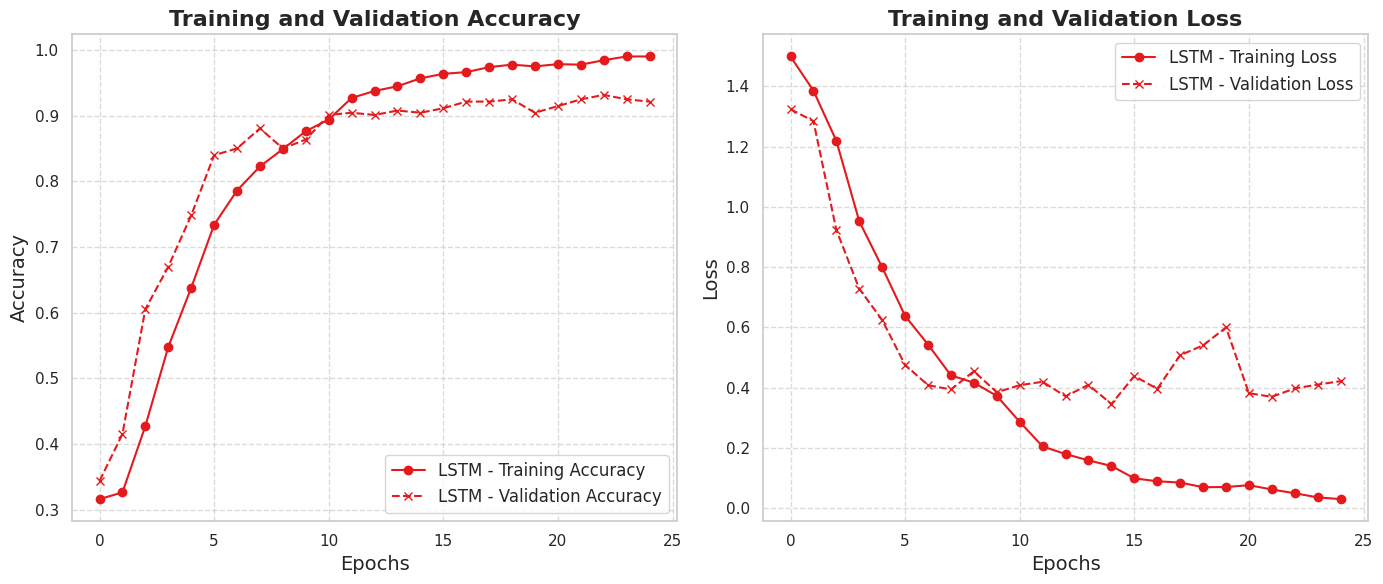

In [12]:
# List of models and their corresponding histories
models = [lstm_model]
histories = [history]
labels = ['LSTM']
# Plot learning curves for all models
plot_learning_curve(histories, labels)

In [17]:
# Evaluate the model on the test set
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)

# Predict the classes for the test set
y_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
model_name = "LSTM"
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

# Print the evaluation results
print(f"{model_name} Loss: {loss:.4f}")
print(f"{model_name} Test Accuracy: {accuracy:.4f}")
print(f"{model_name} Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM Loss: 0.5169
LSTM Test Accuracy: 0.9297
LSTM Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.90      0.91        93
        no_tumor       0.93      0.98      0.95        51
meningioma_tumor       0.92      0.88      0.90        96
 pituitary_tumor       0.95      0.99      0.97        87

        accuracy                           0.93       327
       macro avg       0.93      0.94      0.93       327
    weighted avg       0.93      0.93      0.93       327



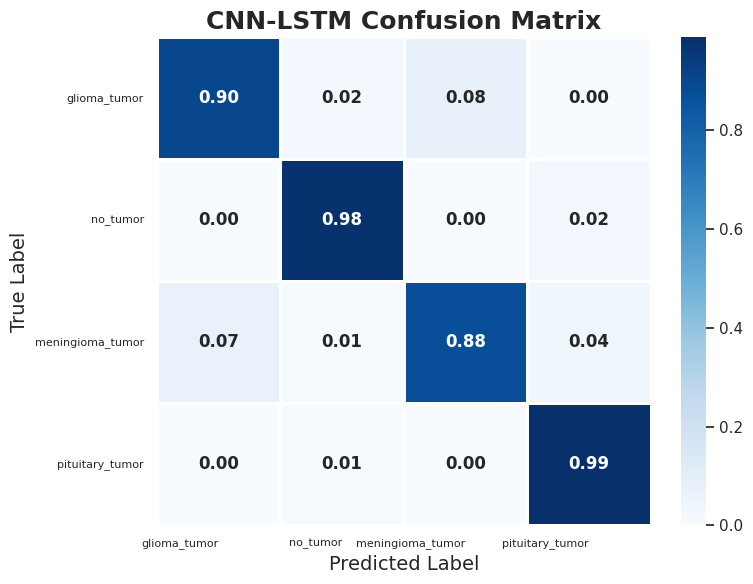

In [26]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a figure and axis for the heatmap
fig, ax = plt.subplots(figsize=(8, 6))  # Adjusted figsize for better spacing
cmap = sns.color_palette("Blues", as_cmap=True)  # Blue color map for a clean look

# Create the heatmap with improved aesthetics
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap=cmap, xticklabels=labels,
            yticklabels=labels, annot_kws={"size": 12, 'weight': 'bold'}, linewidths=1,
            linecolor='white', cbar=True, ax=ax)

# Titles and labels
ax.set_title('CNN-LSTM Confusion Matrix', fontsize=18, weight='bold')
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)

# Rotate the tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right", fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

# Add gridlines with subtle visibility
ax.grid(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
